<a href="https://colab.research.google.com/github/Aladdin60/Project-Silver-swift/blob/main/COLAB/lstm_finalll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
21/21 [==============================] - 28s 330ms/step - loss: 0.1133 - val_loss: 0.1094
Epoch 2/100
21/21 [==============================] - 1s 68ms/step - loss: 0.1123 - val_loss: 0.1116
Epoch 3/100
21/21 [==============================] - 1s 56ms/step - loss: 0.1124 - val_loss: 0.1096
Epoch 4/100
21/21 [==============================] - 1s 67ms/step - loss: 0.1119 - val_loss: 0.1108
Epoch 5/100
21/21 [==============================] - 2s 116ms/step - loss: 0.1122 - val_loss: 0.1101
Epoch 6/100
21/21 [==============================] - 1s 69ms/step - loss: 0.1119 - val_loss: 0.1105
Epoch 7/100
21/21 [==============================] - 1s 66ms/step - loss: 0.1117 - val_loss: 0.1096
Epoch 8/100
21/21 [==============================] - 1s 68ms/step - loss: 0.1113 - val_loss: 0.1108
Epoch 9/100
21/21 [==============================] - 1s 56ms/step - loss: 0.1118 - val_loss: 0.1098
Epoch 10/100
21/21 [==============================] - 1s 55ms/step - loss: 0.1125 - val_loss: 0.1

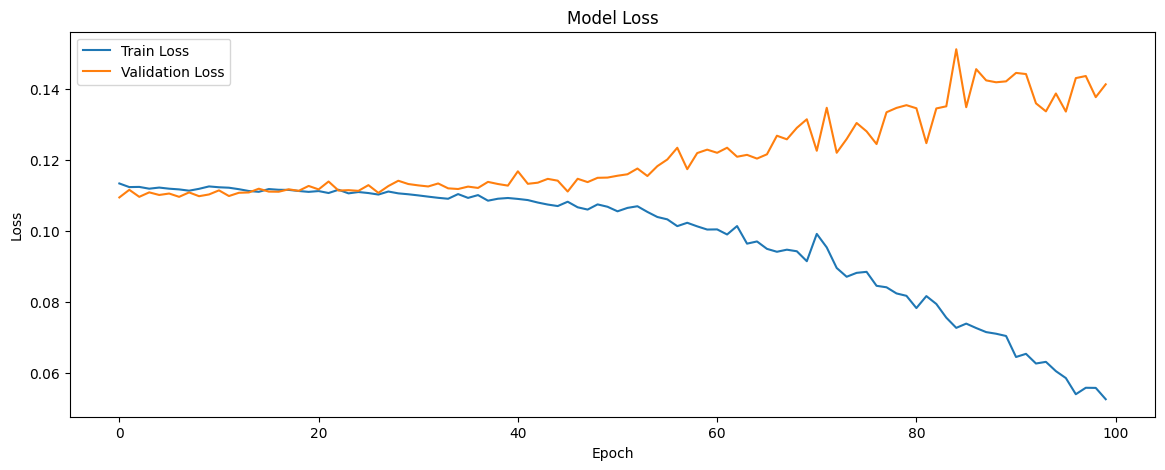

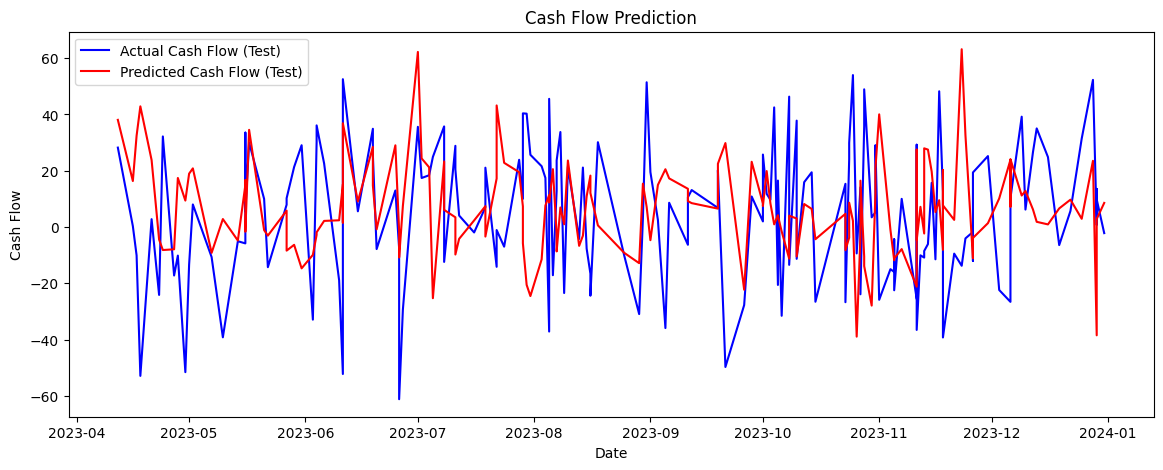

1/1 [==============================] - 0s 54ms/step
Predicted cash flow for the next month: -6.290179


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Load and preprocess the dataset
data = pd.read_excel('cash_flow_data_ final.xlsx')
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data.set_index('Date', inplace=True)

# Target column
target = 'Cash Flow'

# Scaling the data
scaler_cash_flow = MinMaxScaler(feature_range=(-1, 1))
scaled_cash_flow = scaler_cash_flow.fit_transform(data[[target]])

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 12
X, y = create_sequences(scaled_cash_flow, SEQ_LENGTH)

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and testing datasets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Build the LSTM Model
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, 1))),
    Dropout(0.2),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

# Evaluate the model
predicted = model.predict(X_test)
predicted_cash_flow = scaler_cash_flow.inverse_transform(predicted)
y_test_unscaled = scaler_cash_flow.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_unscaled, predicted_cash_flow))
mae = mean_absolute_error(y_test_unscaled, predicted_cash_flow)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot training & validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot actual vs predicted cash flow
plt.figure(figsize=(14, 5))
plt.plot(data.index[SEQ_LENGTH:][len(train_index):], y_test_unscaled, color='blue', label='Actual Cash Flow (Test)')
plt.plot(data.index[SEQ_LENGTH:][len(train_index):], predicted_cash_flow, color='red', label='Predicted Cash Flow (Test)')
plt.title('Cash Flow Prediction')
plt.xlabel('Date')
plt.ylabel('Cash Flow')
plt.legend()
plt.show()

# Predict future cash flows
last_sequence = scaled_cash_flow[-SEQ_LENGTH:]
last_sequence = last_sequence.reshape((1, SEQ_LENGTH, 1))

next_month_prediction = model.predict(last_sequence)
next_month_prediction_cash_flow = scaler_cash_flow.inverse_transform(next_month_prediction.reshape(-1, 1))

print("Predicted cash flow for the next month:", next_month_prediction_cash_flow[0][0])
